# Fitting integral field data with pPXF

In [330]:
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
from os import path

import ppxf as ppxf_package
from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.miles_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning

C = 299792.458  # speed of light in km/s

## Function to read the MUSE cube

In [331]:
class read_muse_cube(object):
    def __init__(self, wave_range):
        """
        Read MUSE cube, log rebin it and compute coordinates of each spaxel.
        Median FWHM resolution = 2.62AA. Range: 2.51--2.88 (ESO instrument manual)
        """
        filename = '../../../Dati/LVS_JWST_workshop_rodeo_cube.fits'  # NGC1386
        hdu = pyfits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data   # cube.shape = (3681, nx, ny)

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1) # create array of spectra [npix, nx*ny]
        wave = head['CRVAL3'] + head['CDELT3']*np.arange(npix)
        pixsize = abs(head["CDELT1"])*3600    # 0.2"

        # Only use the wavelength range in common between galaxy and stellar library.
        w = (wave > wave_range[0]) & (wave < wave_range[1])
        spectra = spectra[w, :]
        wave = wave[w]

        # Create coordinates centred on the brightest spectrum
        flux = np.nanmean(spectra, 0)
        jm = np.argmax(flux)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*pixsize
        y = (row - row[jm])*pixsize
        velscale = C*np.diff(wave[:2])/wave[-1]    # Smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)
        
        self.spectra = spectra
        self.x = x
        self.y = y
        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.flux = flux
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = 2.62  # Median FWHM resolution of MUSE

## Function to iteratively clip the outliers

In [332]:
def clip_outliers(galaxy, bestfit, goodpixels):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma
    in relative error until the bad bins don't change any more.
    """
    while True:
        scale = galaxy[goodpixels] @ bestfit[goodpixels]/np.sum(bestfit[goodpixels]**2)
        resid = scale*bestfit[goodpixels] - galaxy[goodpixels]
        err = robust_sigma(resid, zero=1)
        ok_old = goodpixels
        goodpixels = np.flatnonzero(np.abs(bestfit - galaxy) < 3*err)
        if np.array_equal(goodpixels, ok_old):
            break
            
    return goodpixels

## Function to fit the stellar kinematics

The following function fits the spectrum with `pPXF` while masking the gas emission lines, then iteratively clips the outliers and finally refit the spectrum with `pPXF` on the cleaned spectrum.

In [333]:
def fit_and_clean(templates, galaxy, velscale, start, goodpixels0, dv, lam):
    
    goodpixels = goodpixels0.copy()
    print('##############################################################')
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=8, vsyst=dv, goodpixels=goodpixels, lam=lam)

    plt.figure(figsize=(15,10))
    plt.subplot(211)
    pp.plot()

    goodpixels = clip_outliers(galaxy, pp.bestfit, goodpixels)

    # Add clipped pixels to the original masked emission lines regions and repeat the fit
    goodpixels = np.intersect1d(goodpixels, goodpixels0)
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=8, vsyst=dv, goodpixels=goodpixels, lam=lam)
    
    plt.subplot(212)
    pp.plot()
    plt.pause(0.1)

    optimal_template = templates @ pp.weights
    
    return pp, optimal_template

## Read the data cube and Voronoi bin the data

I only extract the cube over the wavelength region covered by the template library. In this case, other template libraries exist which cover the full MUSE wavelenghth range and could be used instead. I use this library only for simplicity, because it is already distributed with the current version of `pPXF`.

In [334]:
lam_range_temp = [3540, 7409]   # Wavelength range of MILES library
s = read_muse_cube(lam_range_temp)

In this example I request an excessive `target_sn=350` to speed up the calculation. This generates only 9 Voronoi bins. But in a real situation the spatially bined data cube will contain over a hundredVoronoi bins.

In [335]:
signal = np.median(s.spectra, 0)
noise = np.sqrt(signal)
target_sn = 350

Bin-accretion...
1  /  9
2  /  9
3  /  9
4  /  9
5  /  9
6  /  9
7  /  9
8  /  9
9  /  9
10  /  9
11  /  9
12  /  9
13  /  9
13  initial bins.
Reassign bad bins...
9  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 2.993
Iter:    2  Diff: 1.066
Iter:    3  Diff: 0.9984
Iter:    4  Diff: 0.5387
Iter:    5  Diff: 0.3838
Iter:    6  Diff: 0.4701
Iter:    7  Diff: 0.5214
Iter:    8  Diff: 0.3273
Iter:    9  Diff: 0.3003
8  iterations.
Unbinned pixels:  0  /  900
Fractional S/N scatter (%): 8.557297938759246
Elapsed time accretion: 0.17 seconds
Elapsed time optimization: 0.01 seconds


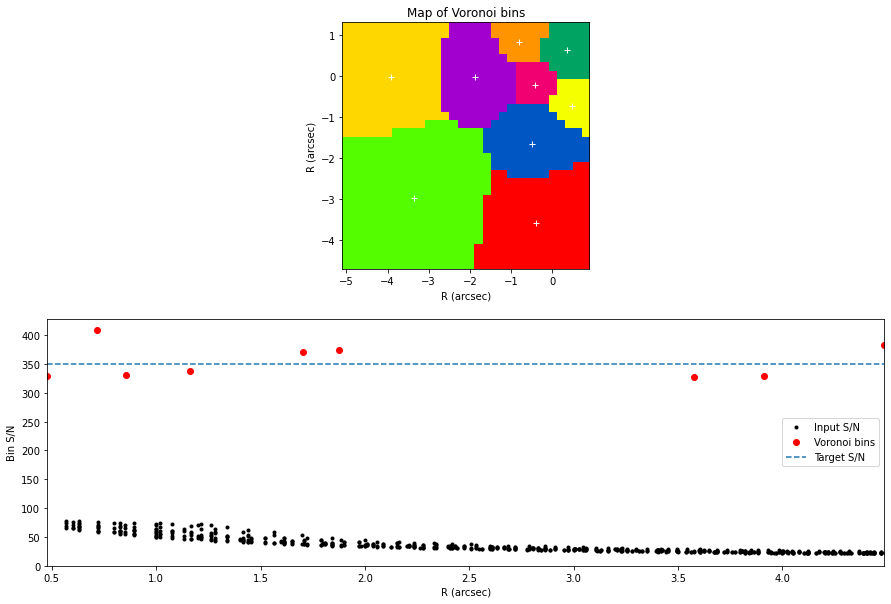

In [336]:
plt.figure(figsize=(15,10))
bin_num, x_gen, y_gen, xbin, ybin, sn, nPixels, scale = voronoi_2d_binning(
    s.x, s.y, signal, noise, target_sn, plot=1, quiet=0, pixelsize=0.2)

## Setup stellar templates

In [337]:
velscale = C*np.diff(s.ln_lam_gal[:2]).item()   # eq.(8) of Cappellari (2017)

In [338]:
ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))
pathname = ppxf_dir + '/miles_models/Mun1.30*.fits'
FWHM_gal = 2.51   # Same as MILES ==> skip templates broadening
miles = lib.miles(pathname, velscale, FWHM_gal, norm_range=[5070, 5950])
stars_templates, ln_lam_temp = miles.templates, miles.ln_lam_temp

The stellar templates are reshaped into a 2-dim array with each spectrum
as a column, however we save the original array dimensions, which are
needed to specify the regularization dimensions


In [339]:
reg_dim = stars_templates.shape[1:]
stars_templates = stars_templates.reshape(stars_templates.shape[0], -1)

See the pPXF documentation for the keyword REGUL,
for an explanation of the following two lines


In [340]:
stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

In [341]:
dv = C*(ln_lam_temp[0] - s.ln_lam_gal[0])  # km/s    eq. (8) of Cappellari (2017)

In [342]:
z = 0.002895  # redshift estimate from NED
vel0 = C*np.log(1 + z)  # Initial estimate of the galaxy velocity in km/s. eq. (8) of Cappellari (2017)
start = [vel0, 200.]  # (km/s), starting guess for [V,sigma]

In [343]:
lam_range_temp = np.exp(ln_lam_temp[[0, -1]])
goodpixels0 = util.determine_goodpixels(s.ln_lam_gal, lam_range_temp, z, width=1000)

## Fit templates and stellar kinematics in Voronoi binned data

In [344]:
nbins = sn.size
velbin, sigbin, nspax = np.zeros((3, nbins))
optimal_templates = np.empty((stars_templates.shape[0], nbins))

In [345]:
npix = s.x.size
ngas_comp = 3
gas_vel, gas_sig = np.zeros((2, npix, ngas_comp))

In [346]:
nlines = 4  #  [NII], Halpha, [OIII], Hbeta
gas_flux, gas_sn = np.zeros((2, npix, ngas_comp, nlines))

In [347]:
%matplotlib inline

##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       856       111
chi2/DOF: 1.210e+07; degree = -1; mdegree = 8
method = capfit; Jac calls: 5; Func calls: 57; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  5 / 150
 Best Fit:       Vel     sigma
 comp.  0:       854       114
chi2/DOF: 2.351e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 8; Func calls: 94; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150


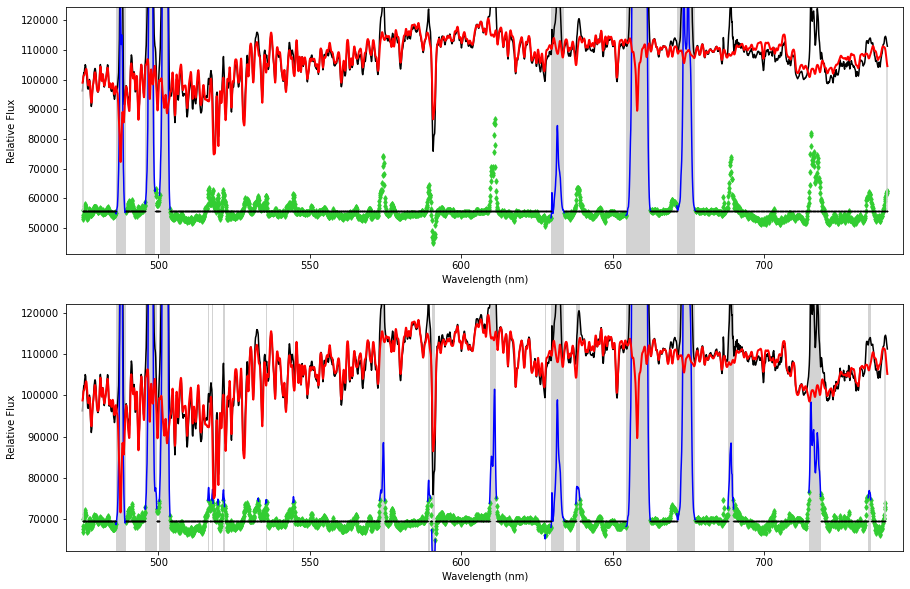

bin: 1 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       930       110
chi2/DOF: 4.927e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 5; Func calls: 57; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma
 comp.  0:       935       114
chi2/DOF: 1.221e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 8; Func calls: 93; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


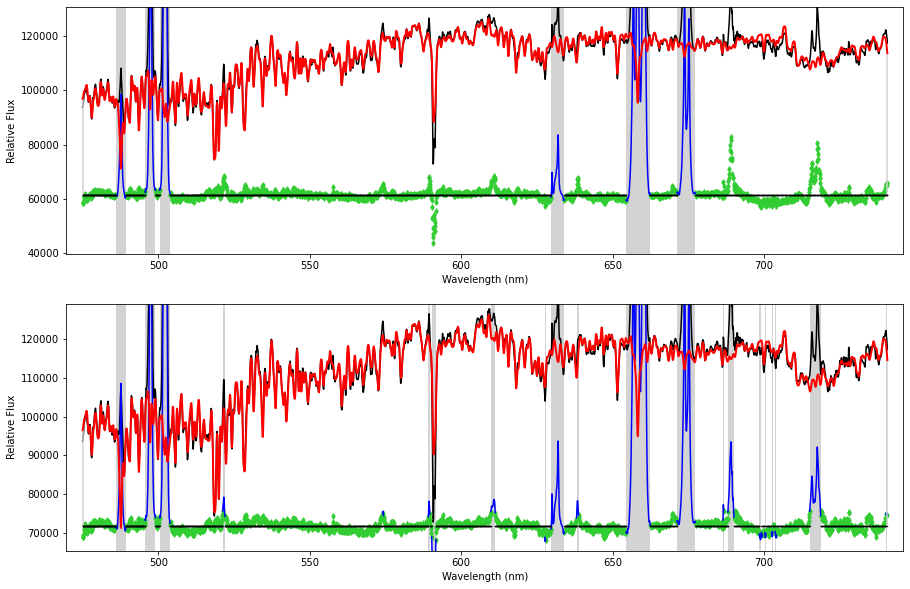

bin: 2 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       894       126
chi2/DOF: 3.859e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 6; Func calls: 69; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma
 comp.  0:       894       129
chi2/DOF: 1.096e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 8; Func calls: 93; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


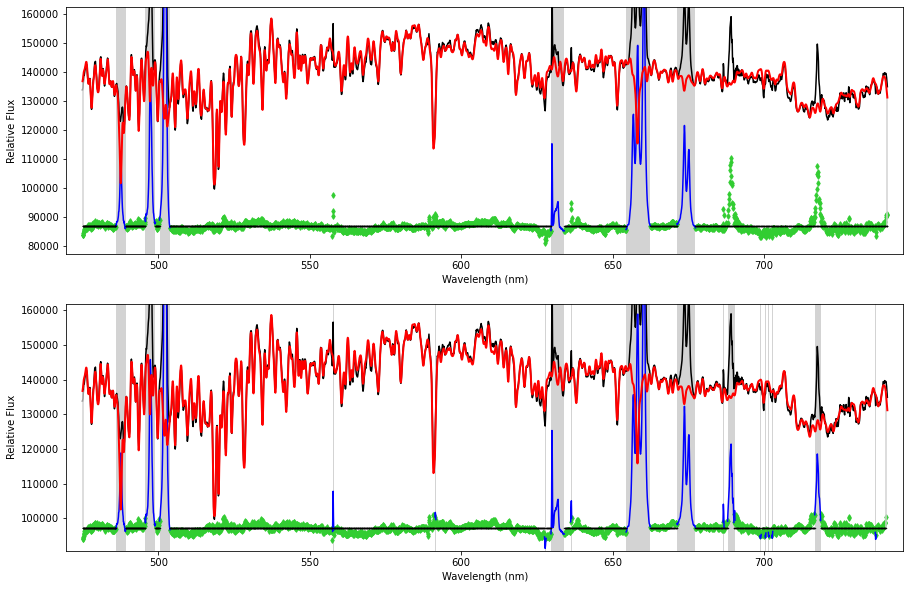

bin: 3 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       813       113
chi2/DOF: 2.139e+07; degree = -1; mdegree = 8
method = capfit; Jac calls: 4; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma
 comp.  0:       822       125
chi2/DOF: 1.472e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 9; Func calls: 101; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


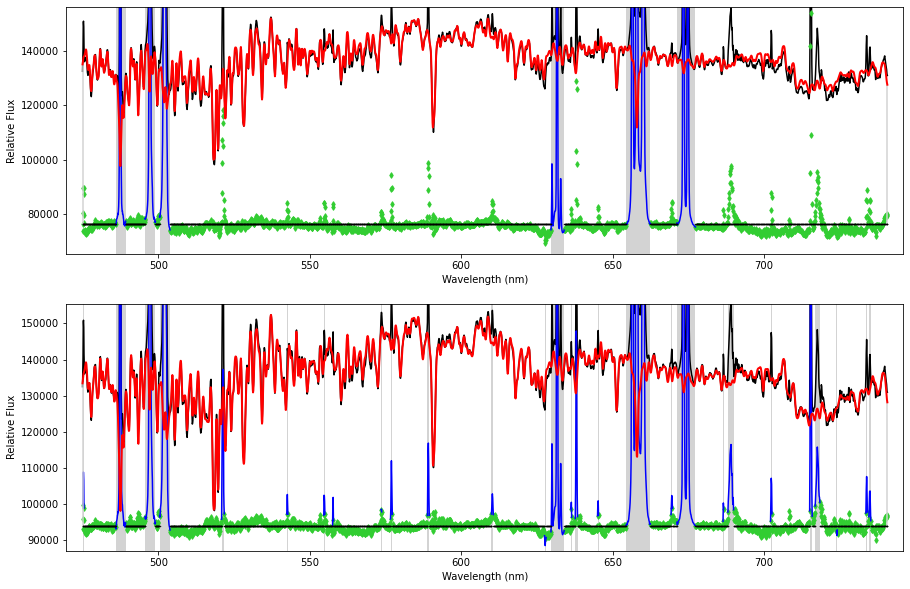

bin: 4 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       856        96
chi2/DOF: 4.910e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 5; Func calls: 61; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  6 / 150
 Best Fit:       Vel     sigma
 comp.  0:       856        97
chi2/DOF: 9.914e+05; degree = -1; mdegree = 8
method = capfit; Jac calls: 9; Func calls: 103; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


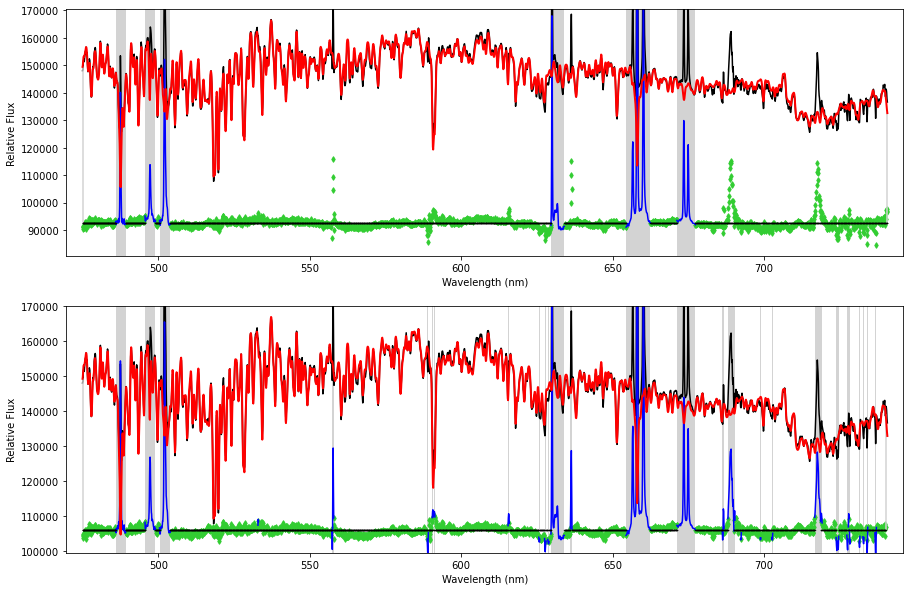

bin: 5 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       902       105
chi2/DOF: 2.488e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 4; Func calls: 46; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  5 / 150
 Best Fit:       Vel     sigma
 comp.  0:       902       106
chi2/DOF: 5.321e+05; degree = -1; mdegree = 8
method = capfit; Jac calls: 9; Func calls: 104; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


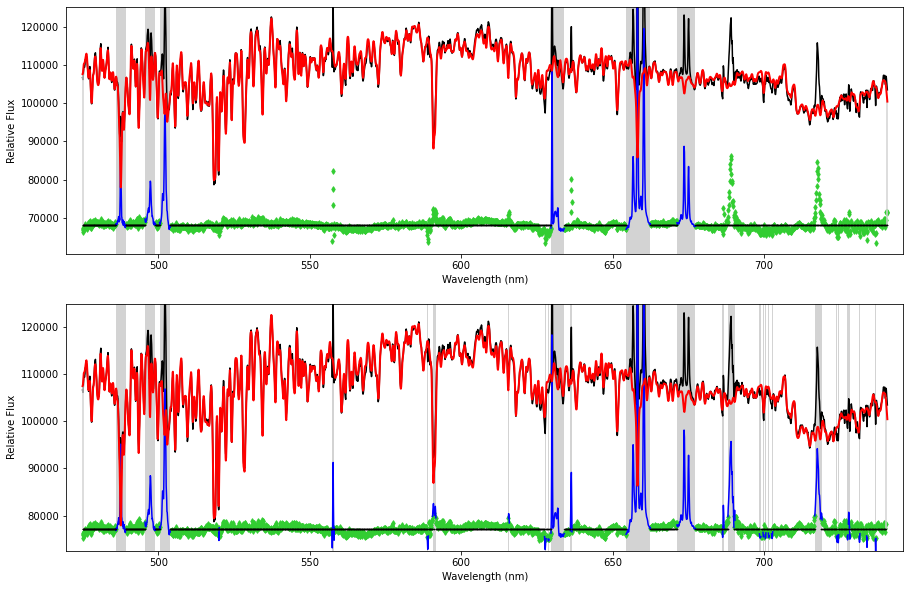

bin: 6 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       814       109
chi2/DOF: 2.802e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 4; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma
 comp.  0:       815       111
chi2/DOF: 5.519e+05; degree = -1; mdegree = 8
method = capfit; Jac calls: 10; Func calls: 114; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150


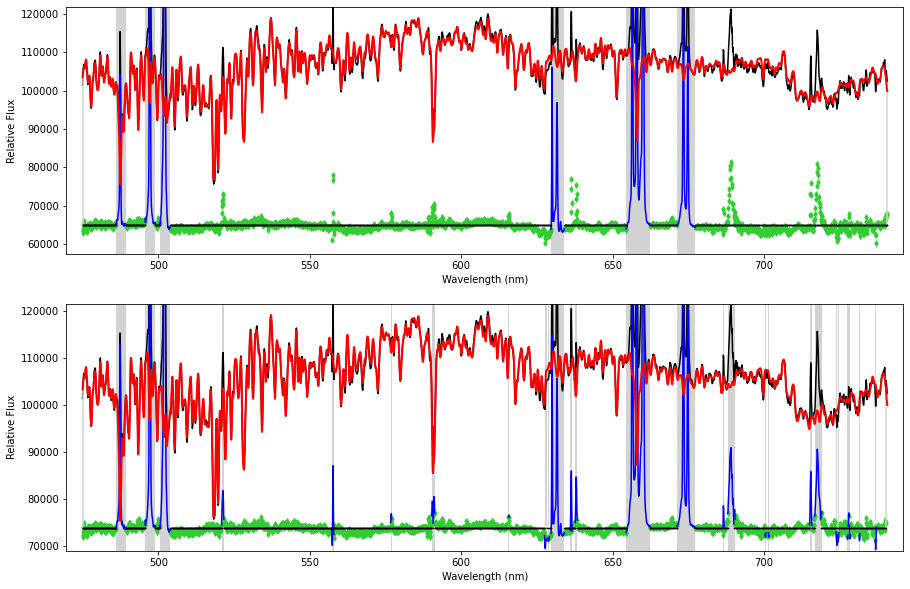

bin: 7 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       796        97
chi2/DOF: 8.670e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 4; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma
 comp.  0:       800       101
chi2/DOF: 1.646e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 6; Func calls: 68; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150


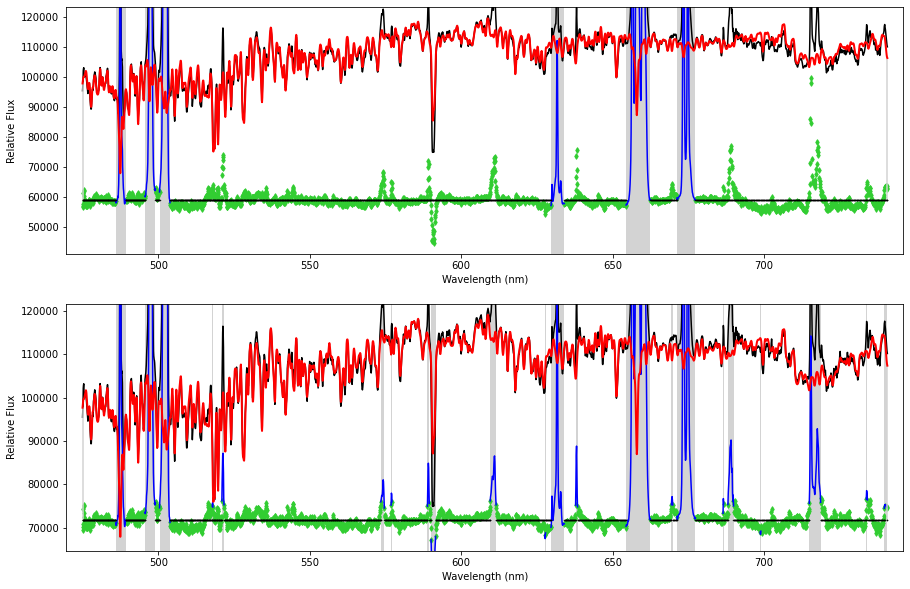

bin: 8 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       879       105
chi2/DOF: 3.000e+07; degree = -1; mdegree = 8
method = capfit; Jac calls: 6; Func calls: 68; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma
 comp.  0:       884       110
chi2/DOF: 4.972e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 11; Func calls: 125; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


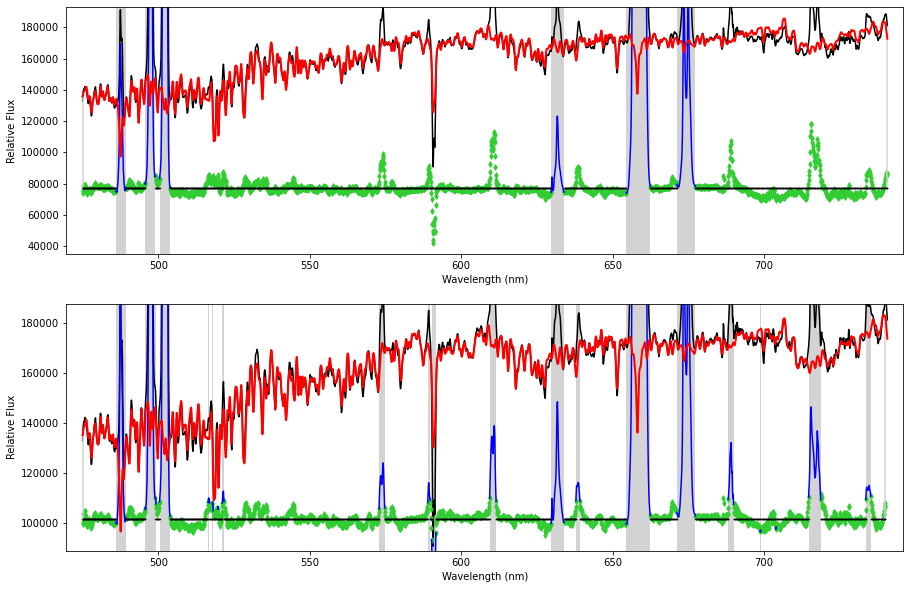

bin: 9 / 9


In [348]:
for j in range(nbins):
    w = bin_num == j
    nspax[j] = w.sum()
    galaxy = np.sum(s.spectra[:, w], 1)
    pp, templates_fitted = fit_and_clean(stars_templates, galaxy, velscale, start, goodpixels0, dv, lam_gal)
    velbin[j], sigbin[j] = pp.sol
    optimal_templates[:, j] = templates_fitted
    print(f'bin: {j + 1} / {nbins}')

## Fit the gas on eaach spaxel

Construct a set of Gaussian emission line templates. They have the width of the instrumental LSF.


In [349]:
lam_gal = np.exp(s.ln_lam_gal)
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(ln_lam_temp, lam_range_gal, s.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d'
 '[NII]6583_d']


Create three sets of gas templates for the set of 7 emission lines which fall within the fitted wavelength range.

In [350]:
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

Here I select a single spaxel for this example. However, in a real analysys this would be replaced by a foor loop over every spaxel

In [351]:
j = 765

In [352]:
galaxy = s.spectra[:, j]

Use as galaxy template the one determined at higher-S/N from the bin containing the current spaxel. I also keep the stellar kinematic fixed to the value determined from that bin.

In [353]:
k = bin_num[j]
template = optimal_templates[:, k]

Fit global template and only gas emission

In [354]:
stars_gas_templates = np.column_stack([template, gas_templates])
component = [0]  # Single stellar kinematic component=0

## Setup of pPXF input parameters

I fit the following 7 gas lines 

H$\beta$, H$\alpha$, [SII]6716, [SII]6731, [OIII]5007d, [OI]6300d, [NII]6583d

I divide the narrow lines into two kinematic `component=1` and `component=2`. I also include a broad kinematic `component=3`.

In [355]:
component += [1]*7
component += [2]*7
component += [3]*7
component = np.asarray(component)

I do not fit the stellar kinematics (I set negative `moments=-2`) but use instead the previously fitted solution for the bin that include the spaxel under analysys. I fit two `moments=2` (V, sigma) for all three gas components

In [356]:
moments = [-2, 2, 2, 2]

In [357]:
# start = [[V1, sig1], [V2, sig2], [V3, sig3], [V4, sig4]]
ncomp = len(moments)
tied = [['', ''] for j in range(ncomp)]
tied[2][1] = 'p[3]'                 # sig3 = sig2
tied[3][0] = '(p[2] + p[4])/2'      # V4 = (V2 + V3)/2

In [358]:
sig_diff = 200  # minimum dispersion difference in km/s
A_ineq = np.array([[0, 0, 0, 1, 0, 0, 0, -1],       # sigma2 - sigma4 < -sigma_diff
                   [0, 0, 0, 0, 0, 1, 0, -1]])      # sigma3 - sigma4 < -sigma_diff
b_ineq = np.array([-sig_diff, -sig_diff])/velscale  # in pixels
constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}

In [359]:
start = [[velbin[k], sigbin[k]],
         [velbin[k], 50],
         [velbin[k], 50],
         [velbin[k], 500]]  # starting guess must be feasible

In [360]:
vlim = lambda x: vsyst + x*np.array([-100, 100])
bounds = [[vlim(2), [20, 300]],
          [vlim(2), [20, 100]],
          [vlim(6), [20, 100]],
          [vlim(2), [20, 1000]]]

## pPXF fit of the gas emission lines

Given that this spectrum contains multiple kinematic components well separated in velocity, the $\chi^2$ necessarily contain multiple minima. For this reason, I set the keyword `global_search=1`. This keyword should be used *only* when the problem has obvious multiple minima, as it is much slower and completely unnecessary in normal situations.

differential_evolution step 1: f(x)= 2.45739e+06
differential_evolution step 2: f(x)= 2.25068e+06
differential_evolution step 3: f(x)= 2.25068e+06
differential_evolution step 4: f(x)= 2.25068e+06
differential_evolution step 5: f(x)= 2.25068e+06
differential_evolution step 6: f(x)= 2.25068e+06
differential_evolution step 7: f(x)= 2.18336e+06
differential_evolution step 8: f(x)= 2.17775e+06
differential_evolution step 9: f(x)= 2.17775e+06
differential_evolution step 10: f(x)= 2.17775e+06
differential_evolution step 11: f(x)= 2.17775e+06
differential_evolution step 12: f(x)= 2.17775e+06
 Best Fit:       Vel     sigma
 comp.  0:       894       129
 comp.  1:      1016        91
 comp.  2:       835        91
 comp.  3:       926       345
chi2/DOF: 826.0; degree = 8; mdegree = 0
Global search - Func calls: 622
method = capfit; Jac calls: 2; Func calls: 12; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  20 / 22
Tied parameters:
 p[5] = p[3]
 p[6] = (p[2] + p[4])/2
+++++++++

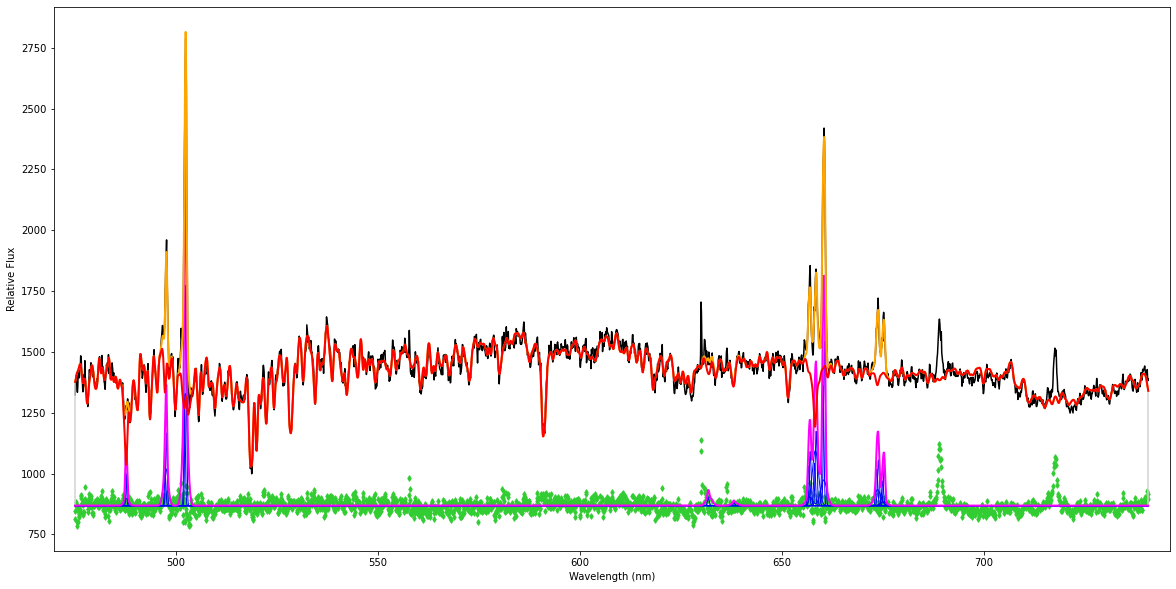

In [364]:
plt.figure(figsize=(20,10))
pp = ppxf(stars_gas_templates, galaxy, galaxy*0 + 1, velscale, start,
          plot=1, moments=moments, degree=8, mdegree=-1, vsyst=dv,
          component=component, gas_component=component > 0, tied=tied,
          gas_names=gas_names, constr_kinem=constr_kinem, lam=lam_gal,
          bounds=bounds, global_search=1)

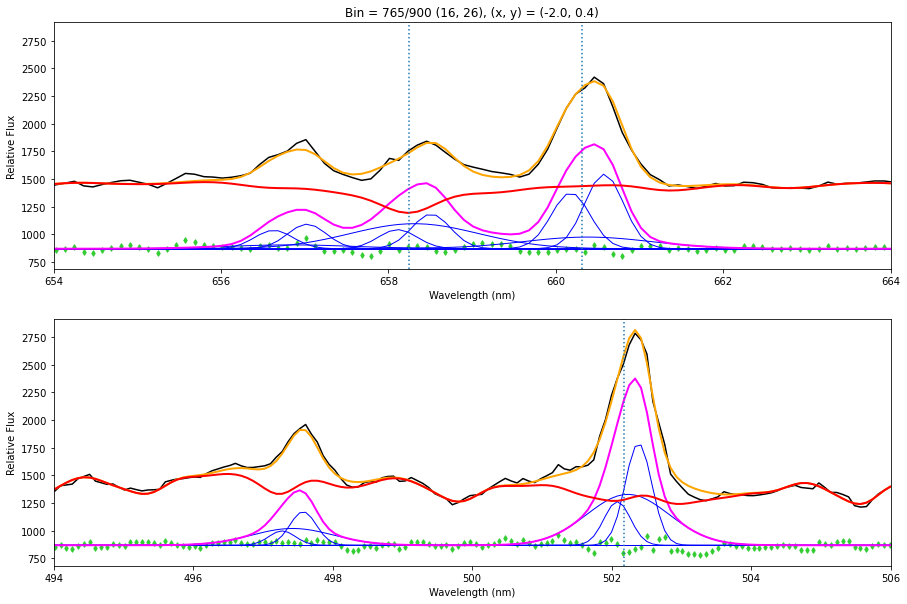

In [365]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.title(f"Bin = {j}/{npix} ({s.col[j]}, {s.row[j]}), (x, y) = ({s.x[j]:.1f}, {s.y[j]:.1f})")
pp.plot()
[plt.axvline(lam*np.exp(velbin[k]/C)/10, ls=':') for lam in lams]
plt.xlim([654, 664])

plt.subplot(212)
pp.plot()
[plt.axvline(lam*np.exp(velbin[k]/C)/10, ls=':') for lam in lams]
plt.xlim([494, 506]);

The `pPXF` documentation [HERE](https://pypi.org/project/ppxf/#output-parameters) states:

"IMPORTANT: ``pPXF`` makes no assumptions about the input flux units:
The returned ``.gas_flux`` has the same units and values one would
measure (with lower accuracy) by summing the pixels values, within the
given gas lines, on the continuum-subtracted input galaxy spectrum.
This implies that, if the spectrum is in units of ``erg/(s cm^2 A)``,
the ``.gas_flux`` returned by ``pPXF`` should be multiplied by the pixel
size in Angstrom at the line wavelength to obtain the integrated line
flux in units of ``erg/(s cm^2)``."

For this reason, below I multiply the flux returned by `pPXF` by the pixel size at the wavelength of each line.


In [363]:
noise = robust_sigma(galaxy - pp.bestfit, zero=1)

names = ['Halpha', 'Hbeta' , '[NII]6583_d', '[OIII]5007_d']
for p, name in enumerate(names):
    kk = gas_names == name + '_(1)'   # Extract first component
    dlam = line_wave[kk]*velscale/C   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
    flux = (pp.gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
    print(f"{name} - gas flux: {flux:.4g} ergs/(cm^2 s)") 
    an = np.max(pp.gas_bestfit_templates[:, kk])/noise
    print(f"{name} - Amplitude/Noise: {an:.4g}\n") 

Halpha - gas flux: 998 ergs/(cm^2 s)
Halpha - Amplitude/Noise: 7.364

Hbeta - gas flux: 654.1 ergs/(cm^2 s)
Hbeta - Amplitude/Noise: 5.956

[NII]6583_d - gas flux: 3899 ergs/(cm^2 s)
[NII]6583_d - Amplitude/Noise: 21.05

[OIII]5007_d - gas flux: 2491 ergs/(cm^2 s)
[OIII]5007_d - Amplitude/Noise: 16.79

